<a href="https://colab.research.google.com/github/ChithraSivan/ADL_project-Image_Caption_generator/blob/main/Improvisation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow.keras
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import sys
import pickle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
import string
import numpy as np
from pickle import load
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM ,GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout, Reshape, Lambda, Concatenate
from tensorflow.python.keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from nltk.translate.bleu_score import corpus_bleu



In [ ]:
def Indicator(value, endvalue, leng=20,job='Job'):

    percent = float(value) / endvalue
    move= '-' * int(round(percent * leng)-1) + '>'
    tab = ' ' * (leng - len(a))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,move + tab, int(round(percent * 100))))
    sys.stdout.flush()

In [ ]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	#Taking each line
	for line in doc.split('\n'):
		
		if len(line) < 1:
			continue
		# fetching image ID
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return list(set(dataset))

def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
doc = load_doc("/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [ ]:
embedding_dimension = 50
batch_size = 32
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # extracting filename
        image_id = image_id.split('.')[0]
        #tokens  to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except :
        print(line)

In [ ]:
def clean_data(pairs):
    # removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            desc = [word.lower() for word in desc]           
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>0]
            # remove numbers
            desc = [word for word in desc if word.isalpha()]
            # convert into string
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

In [ ]:
descriptions_clean = clean_data(descriptions)


In [ ]:
start_token = '<startseq>'
end_token = '<endseq>'
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [ ]:
tokenss = add_end_start_tokens(descriptions_clean)
tokenss[next(iter(tokenss))]

['<startseq> a child in a pink dress is climbing up a set of stairs in an entry way <endseq>',
 '<startseq> a girl going into a wooden building <endseq>',
 '<startseq> a little girl climbing into a wooden playhouse <endseq>',
 '<startseq> a little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> a little girl in a pink dress going into a wooden cabin <endseq>']

In [ ]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]
        
    return dataset_

In [ ]:
train_img_path = '/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
test_img_path = '/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
dev_imgs_path = '/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'

train_img = load_set(train_img_path)
test_img = load_set(test_img_path)
dev_img= load_set(dev_imgs_path)



In [ ]:
train_descriptions = load_train_test(tokenss, train_img)
test_descriptions = load_train_test(tokenss, test_img)
dev_descriptions = load_train_test(tokenss, dev_img)

In [ ]:
def repeating_vocabulary(descriptions, count_limit = 10):
    sentences = []
    for key, val in descriptions.items():
        for sen in val:
            sentences.append(sen)

    # Count limit=10
    word_counts = {}
    ncap = 0
    for sent in sentences:
        ncap += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    v = [w for w in word_counts if word_counts[w] >= count_limit]

    return v

In [ ]:
vocab = repeating_vocabulary(train_descriptions, count_limit = 5)
sorted(vocab)[:10]

['<endseq>',
 '<startseq>',
 'a',
 'about',
 'above',
 'accordion',
 'acrobatic',
 'across',
 'act',
 'action']

In [ ]:
unknown_token = '<UNK>'
nonalphachar = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' 
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(filters = nonalphachar, oov_token=unknown_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)

vocab_size : 2535


In [ ]:
ixtoword = {} 
wordtoix = {} 
tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index 
for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

In [ ]:
#finding maximum length
def max_length(desc,p):
    all_cap = []
    for i in desc:
        for j in desc[i]:
            all_cap.append(j)

    length_all_cap = list(len(d.split()) for d in all_cap)

    print('percentile {} of len of questions: {}'.format(p,np.percentile(length_all_cap, p)))
    print('longest sentence: ', max(length_all_cap))

    return int(np.percentile(length_all_cap, p))

max_len = max_length(train_descriptions,90)

print('max-len answer for training: ', max_len)

percentile 90 of len of questions: 18.0
longest sentence:  37
max-len answer for training:  18


In [ ]:
xception = Xception()
modelxception = Model(inputs=xception.inputs, outputs=xception.layers[-2].output) 
print(modelxception.summary())

91897856/91884032 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [ ]:
def extract_features(description, model, inpute_size = (299,299)):
    directory = '/content/drive/My Drive/Flickr_Data/Images'
    features = {}
    i = 0
    for name in description:
        Indicator(value=i,endvalue=len(descriptions))
        i +=1
        filename =os.path.join(directory, name+'.jpg')
        image = load_img(filename, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature.reshape(2048)
    return features

In [ ]:
with open('/content/drive/My Drive/dev_features.pkl','wb') as f:
   pickle.dump(dev_features,f)
with open('/content/drive/My Drive/train_features.pkl','wb') as f:
   pickle.dump(train_features,f)
with open('/content/drive/My Drive/test_features.pkl','wb') as f:
   pickle.dump(test_features,f)
  

Job Completion: [->                  ] 12%

In [ ]:
with open('/content/drive/My Drive/dev_features.pkl','rb') as f:
    dev_features= pickle.load(f)    
with open('/content/drive/My Drive/train_features.pkl','rb') as f:
    train_features= pickle.load(f)
with open('/content/drive/My Drive/test_features.pkl','rb') as f:
    test_features= pickle.load(f)

In [ ]:
def data_generator(descriptions, photos):
    X1, X2, y = [], [], []
    n=0
    while 1:
        for key, value in descriptions.items():
            n+=1
            photo = photos[key]
            for cap in value:
                vocabseq = tokenizer.texts_to_sequences(cap.split())
                for i in range(1, len(vocabseq)):
                    in_vocabseq, out_vocabseq= vocabseq[:i], vocabseq[i] 
                    in_vocabseq = pad_sequences([in_vocabseq], maxlen=max_length)[0]

                    X1.append(photo)
                    X2.append(in_vocabseq)
                    y.append(out_vocabseq)
            if n == batch_size:
                #return the batch data 
                yield ([np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
def glove_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('null matrix ')
        mat = np.zeros((vocab_size, embedding_dim)) 
    else:
        glove_dir = '/content/drive/My Drive/glove'
        index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            strg = np.asarray(values[1:], dtype='float32')
            index[word] = strg
        f.close()
       mat = np.zeros((vocab_size, embedding_dim)) 
        for word, i in wordtoix.items():
            vec = index.get(word)
            if vec is not Nchone:
                
                mat[i] = vec
        print('GloVe loaded!')
        
    l = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    l.build((None,))
    l.set_weights([mat])
    
    return l

In [ ]:
em_glove_layer = glove_layer(embedding_dimension, glove=True)

In [ ]:
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
from keras.layers import RepeatVector
def define_model(embedding ,dout= 0.2, feature_size= 2048, units= 256):
    
    ip1 = Input(shape=(feature_size,)) 
    ip2_one_dim = Dense(units, activation='relu')(ip1) 
    ip3 = RepeatVector(max_length)(ip2_one_dim)
    ip3 = Dropout(dout)(ip3)
    
    se1 = Input(shape=(max_length,))
    se2 = embedding(se1)
    se2 = Lambda(lambda x: x, output_shape=lambda s:s)(se2) 
    se2 = Dropout(dout)(se2)
    se2 = Concatenate(name='concat_features_word_embeddings', axis=-1)([ip3,se2])
    se2 = GRU(units, return_sequences=True)(se2,initial_state=ip2_one_dim) 
    se2 = Dropout(dout + 0.2)(se2)
    se2 = GRU(units, return_sequences=False)(se2)

    outputs = Dense(vocab_size, activation='softmax')(se2)
    model = Model(inputs=[features, seq], outputs = outputs)
    return model

In [ ]:
model = define_model(em_glove_layer)
model.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          524544      input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 50)       126750      input_3[0][0]                    
______________________________________________________________________

In [ ]:
model.compile(loss=masked_loss_function, optimizer= 'adam')

In [ ]:
history={'loss':[], 'BLEU_val':[]}

In [ ]:
# greedy search
def generator(model, photo_fe, inference= False):
     caption = start_token
    for i in range(max_length):
        s1 = tokenizer.texts_to_sequences(caption.split()) 
        photo_fe = photo_fe.reshape((1,2048))
        s1 = pad_sequences([s1], maxlen=max_length).reshape((1,max_length))
        #predict the next word
        pred = model.predict([photo_fe,s1], verbose=0) 
        #probability     
        pred = np.argmax(pred)      
        word = ixtoword[pred]
      
        if word is None:
            break
       caption += ' ' + word
        if word == end_token:
            break
            
    if inference == True:
        caption = caption.split()
        if len(caption) == max_length:
            caption = caption[1:] 
        else:
            caption = caption[1:-1]
        caption = ' '.join(caption)
        
    return caption

In [ ]:
#beam search
def beam_search_prediction(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start = [wordtoix[start_token]]    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #
            preds = model.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:]            
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) 
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
     
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

    
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
# calculating BLEU score 
def get_bleu_score(model, descriptions, photos_fe, K_beams= 3, log=False):
    actual, predicted = list(), list()
    i=0
    for key, desc_list in descriptions.items():
        i+=1
        Indicator(i, len(descriptions), bar_length=20,job='Evaluating')
        if K_beams == 1:
            yhat = generator(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)
        
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1,b2,b3,b4]

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)

In [ ]:
steps = len(train_descriptions)//batch_size

In [ ]:
# create the data generator
generator = data_generator(train_descriptions, train_features)

In [ ]:
ep=1

In [ ]:
for i in range(ep, 50):
    
    print('Epoch :',i,'\n')
    # fit for one epoch
    h = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])
    
    # save model every 3 epochs
    if i % 3 == 0:
        test() 
        model.save('/content/drive/My Drive/Models2'+'/modelXception_' + str(i) + '.h5')
        belus= get_bleu_score(model, dev_descriptions, dev_features, K_beams=1)    
        history['BLEU_val'].append((belus,i))

    print('\n','='*80)

Epoch : 1 



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


187/187 [==============================] - 30s 127ms/step - loss: 5.0360

Epoch : 2 

187/187 [==============================] - 24s 127ms/step - loss: 4.5621

Epoch : 3 

187/187 [==============================] - 24s 127ms/step - loss: 4.0524
====
Greedy: a man in a red shirt is jumping a <UNK>
Greedy: a man is jumping a <UNK>
Greedy: a man in a red shirt is jumping on a <UNK>
Greedy: a man in a red shirt is jumping a <UNK> in the water
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.592981
BLEU-2: 0.377537
BLEU-3: 0.265659
BLEU-4: 0.139240

Epoch : 4 

187/187 [==============================] - 24s 129ms/step - loss: 3.6689

Epoch : 5 

187/187 [==============================] - 24s 126ms/step - loss: 3.4067

Epoch : 6 

187/187 [==============================] - 24s 127ms/step - loss: 3.2282
====
Greedy: a man in a red shirt and a black shirt and black shirt is standing on a
Greedy: a dog is standing in the snow
Greedy: a man is jumping on a bench
Greedy: a man i

In [ ]:

i=18
model=tensorflow.keras.models.load_model('/content/drive/My Drive/Models2'+'/modelXception_' + str(i) + '.h5',custom_objects={'masked_loss_function':masked_loss_function})

In [ ]:
get_bleu_score(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.641812
BLEU-2: 0.448058
BLEU-3: 0.348498
BLEU-4: 0.214083


[0.6418115542092452,
 0.4480580696852576,
 0.3484976403377815,
 0.2140828080203517]

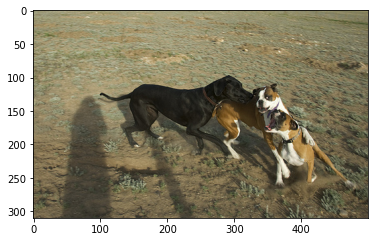

Greedy: a brown dog is running on a grassy path
Beam K= 3: a brown dog and a brown dog are playing in the snow
Beam K= 5: a brown dog and a brown dog are playing in the snow
Beam log K= 3: a brown dog and a brown dog are playing in the snow
Beam log K= 5: a brown dog and a brown dog are playing in the snow


In [ ]:
image = list(test_features.keys())[560]
f1 = test_features[image].reshape((1,2048))
picture=plt.imread('/content/drive/My Drive/Flickr_Data/Images/'+pic+'.jpg')
plt.imshow(picture)
plt.show()
print("Greedy:",generator(model, f1, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 5, log=True))

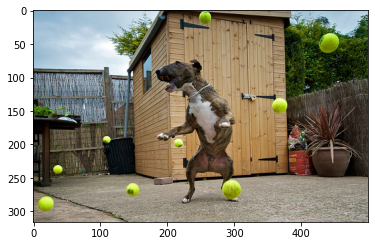

Greedy: a dog jumps a ball in a field
Beam K= 3: a dog catches a tennis ball in the grass
Beam K= 5: a dog catches a tennis ball with a ball in its mouth
Beam log K= 3: a black and white dog catches a tennis ball in the air
Beam log K= 5: a dog catches a ball in the air to catch a tennis ball


In [ ]:
image = list(test_features.keys())[990]
f1 = test_features[image].reshape((1,2048))
picture=plt.imread('/content/drive/My Drive/Flickr_Data/Images/'+pic+'.jpg')
plt.imshow(picture)
plt.show()
print("Greedy:",generator(model, f1, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 5, log=True))

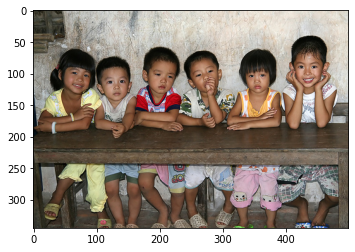

Greedy: two children are playing in a park
Beam K= 3: two children playing in a park
Beam K= 5: two children playing in a park
Beam log K= 3: two children are playing in a park
Beam log K= 5: two children playing in a park


In [ ]:
image = list(test_features.keys())[200]
f1 = test_features[image].reshape((1,2048))
picture=plt.imread('/content/drive/My Drive/Flickr_Data/Images/'+pic+'.jpg')
plt.imshow(picture)
plt.show()
print("Greedy:",generator(model, f1, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[image], wordtoix, K_beams = 5, log=True))